<a href="https://colab.research.google.com/github/ryzhokhina/Tensorflow-Dev-Exam-Preparation/blob/main/06_transfer_learning_scale_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
!nvidia-smi

Wed Jul 12 20:50:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-12 20:50:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-12 20:50:51 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir



In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-07-12 20:50:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 74.125.128.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  38.6MB/s    in 40s     

2023-07-12 20:51:32 (38.4 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
unzip_data('/content/101_food_classes_10_percent.zip')
train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

In [7]:
walk_through_dir(train_dir)

There are 101 directories and 0 images in '101_food_classes_10_percent/train/'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/scallops'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cup_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/oysters'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/edamame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/nachos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/garlic_bread'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tacos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/churros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '101

In [8]:
walk_through_dir(test_dir)

There are 101 directories and 0 images in '101_food_classes_10_percent/test/'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/scallops'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/oysters'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/edamame'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/nachos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_bolognese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tacos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/churros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '101

In [9]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE)

Found 7575 files belonging to 101 classes.


In [10]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)



Found 25250 files belonging to 101 classes.


More specifically, our goal will be to see if we can beat the baseline from original Food101 paper (50.76% accuracy on 101 classes) with 10% of the training data and the following modelling setup:

* A ModelCheckpoint callback to save our progress during training, this means we
could experiment with further training later without having to train from scratch every time
* Data augmentation built right into the model
* A headless (no top layers) EfficientNetB0 architecture from tf.keras.applications as our base model
A Dense layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer
Categorical crossentropy as the loss function since we're dealing with more than two classes
The Adam optimizer with the default settings
* Fitting for 5 full passes on the training data while evaluating on 15% of the test data



In [11]:
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)



In [12]:
from keras import Sequential
from keras.layers import RandomFlip,RandomHeight, RandomWidth,RandomZoom, Rescaling, RandomRotation

data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomHeight(0.2),
    RandomWidth(0.2),
    RandomZoom(0.2)], name = 'data_augmentation')

In [13]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SIZE +(3,), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(101, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, x)




16705208/16705208 [==============================] - 1s 0us/step


In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [16]:
history_10_percent_data_aug = model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=int(0.15* len(test_data)),
                                        callbacks=[checkpoint_callback])



Epoch 1/5
237/237 [==============================] - 107s 381ms/step - loss: 3.2205 - accuracy: 0.3155 - val_loss: 2.3313 - val_accuracy: 0.4791
Epoch 2/5
237/237 [==============================] - 67s 281ms/step - loss: 1.9659 - accuracy: 0.5546 - val_loss: 1.9074 - val_accuracy: 0.5328
Epoch 3/5
237/237 [==============================] - 58s 244ms/step - loss: 1.5745 - accuracy: 0.6293 - val_loss: 1.7399 - val_accuracy: 0.5514
Epoch 4/5
237/237 [==============================] - 54s 228ms/step - loss: 1.3438 - accuracy: 0.6826 - val_loss: 1.6722 - val_accuracy: 0.5633
Epoch 5/5
237/237 [==============================] - 51s 216ms/step - loss: 1.1793 - accuracy: 0.7204 - val_loss: 1.6402 - val_accuracy: 0.5628


In [17]:
model.evaluate(test_data)


790/790 [==============================] - 48s 61ms/step - loss: 1.4934 - accuracy: 0.6055


[1.4933679103851318, 0.6055049300193787]

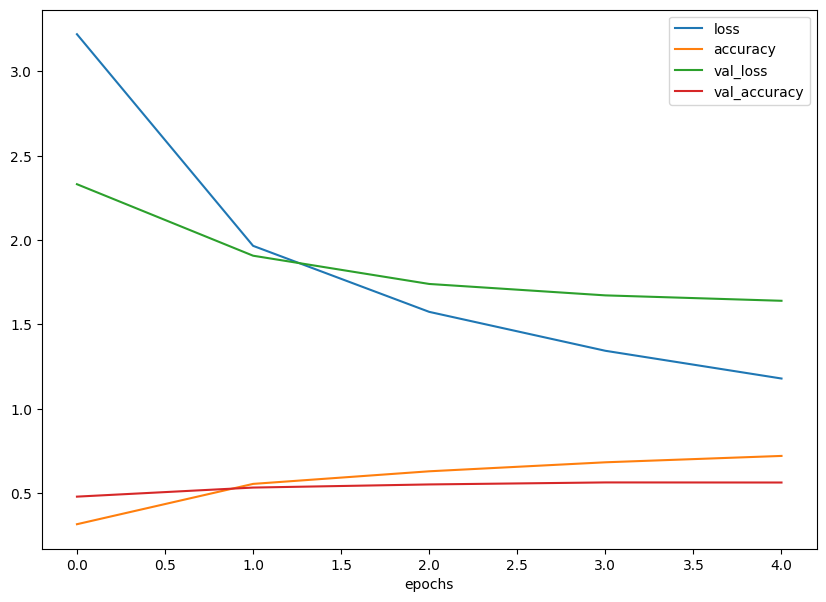

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history_10_percent_data_aug.history).plot(figsize=(10,7), xlabel='epochs')
plt.show()


## Fine-tuning

In [19]:
base_model.trainable = True

for l in base_model.layers[:-5]:
  l.trainable = False

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 910,821
Non-trainab

In [21]:
history_fine_10_percent_data_aug = model.fit(train_data_10_percent,
                                             epochs=10,
                                             steps_per_epoch=len(train_data_10_percent),
                                             validation_data=test_data,
                                             validation_steps=int(len(test_data)),
                                             initial_epoch=history_10_percent_data_aug.epoch[-1],
                                             callbacks=[checkpoint_callback])


Epoch 5/10
237/237 [==============================] - 96s 367ms/step - loss: 0.9314 - accuracy: 0.7592 - val_loss: 1.4347 - val_accuracy: 0.6155
Epoch 6/10
237/237 [==============================] - 83s 350ms/step - loss: 0.8084 - accuracy: 0.7883 - val_loss: 1.4312 - val_accuracy: 0.6190
Epoch 7/10
237/237 [==============================] - 82s 344ms/step - loss: 0.7194 - accuracy: 0.8139 - val_loss: 1.4286 - val_accuracy: 0.6216
Epoch 8/10
237/237 [==============================] - 79s 334ms/step - loss: 0.6554 - accuracy: 0.8325 - val_loss: 1.4394 - val_accuracy: 0.6198
Epoch 9/10
237/237 [==============================] - 77s 326ms/step - loss: 0.6009 - accuracy: 0.8446 - val_loss: 1.4373 - val_accuracy: 0.6232
Epoch 10/10
237/237 [==============================] - 77s 326ms/step - loss: 0.5475 - accuracy: 0.8581 - val_loss: 1.4447 - val_accuracy: 0.6238


In [22]:
model.evaluate(test_data)



790/790 [==============================] - 48s 60ms/step - loss: 1.4447 - accuracy: 0.6238


[1.4447213411331177, 0.6238020062446594]

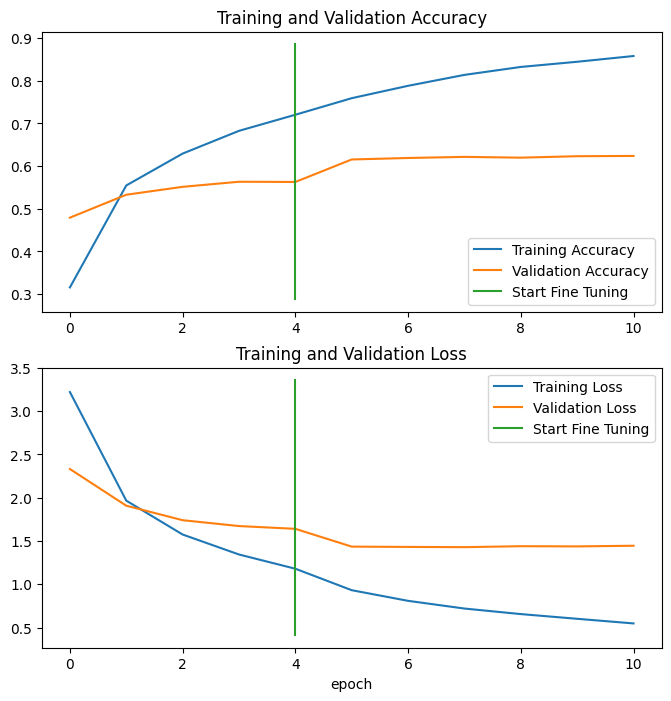

In [23]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)


In [24]:
predicts = model.predict(test_data, verbose=1)

print(len(predicts))

790/790 [==============================] - 46s 56ms/step
25250


In [25]:
predicts.shape

(25250, 101)

In [26]:
len(test_data)

790

In [27]:
predicts_class = predicts.argmax(axis=1)

In [28]:
predicts_class

array([  0,   0,   0, ..., 100,   8, 100])

In [29]:
len(predicts_class)

25250

In [30]:
predicts[0]

array([1.6788949e-01, 1.4486435e-04, 4.8693635e-02, 2.8002199e-07,
       1.7407452e-05, 2.5391284e-06, 7.3839183e-05, 6.5700019e-06,
       3.1268444e-02, 1.7240843e-04, 4.3244377e-06, 1.7046457e-05,
       1.4637577e-03, 7.5623103e-07, 2.1054696e-02, 5.2102944e-03,
       3.5501976e-04, 1.2011223e-04, 3.0896291e-02, 1.9623645e-05,
       4.4021690e-03, 1.6052471e-05, 9.8657933e-05, 4.0620711e-05,
       3.7503336e-03, 1.0173795e-02, 2.9613983e-03, 3.5772318e-05,
       1.3209593e-01, 8.1875408e-04, 7.5580709e-07, 9.9646591e-04,
       3.0788165e-04, 8.7574881e-07, 4.0663406e-04, 3.1696852e-06,
       7.0999790e-04, 3.2957296e-03, 3.5922792e-02, 1.2888681e-04,
       1.0511086e-03, 3.7336643e-03, 6.0418312e-04, 2.9818337e-05,
       4.1975657e-04, 1.9005593e-04, 1.1697059e-03, 9.8618519e-05,
       1.1592656e-05, 1.0379509e-01, 5.8130216e-04, 4.0793075e-05,
       3.3823024e-02, 1.6583046e-02, 7.1948358e-05, 2.3822902e-02,
       2.8884547e-02, 2.2506348e-03, 6.9096261e-03, 5.8755588e

In [31]:
predicts_class[0]

0

In [32]:
max(predicts[0])

0.16788949

In [33]:
sum(predicts[0])


1.0000000337755637

In [34]:
test_data.unbatch()

<_UnbatchDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(101,), dtype=tf.float32, name=None))>

In [35]:
y_label = []
for _, cl in test_data.unbatch():
  y_label.append(cl.numpy().argmax())

In [36]:
len(y_label)

25250

In [37]:
y_label[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [38]:
from sklearn.metrics import confusion_matrix
mtrx = confusion_matrix(y_label, predicts_class)


In [39]:
from sklearn.metrics import ConfusionMatrixDisplay

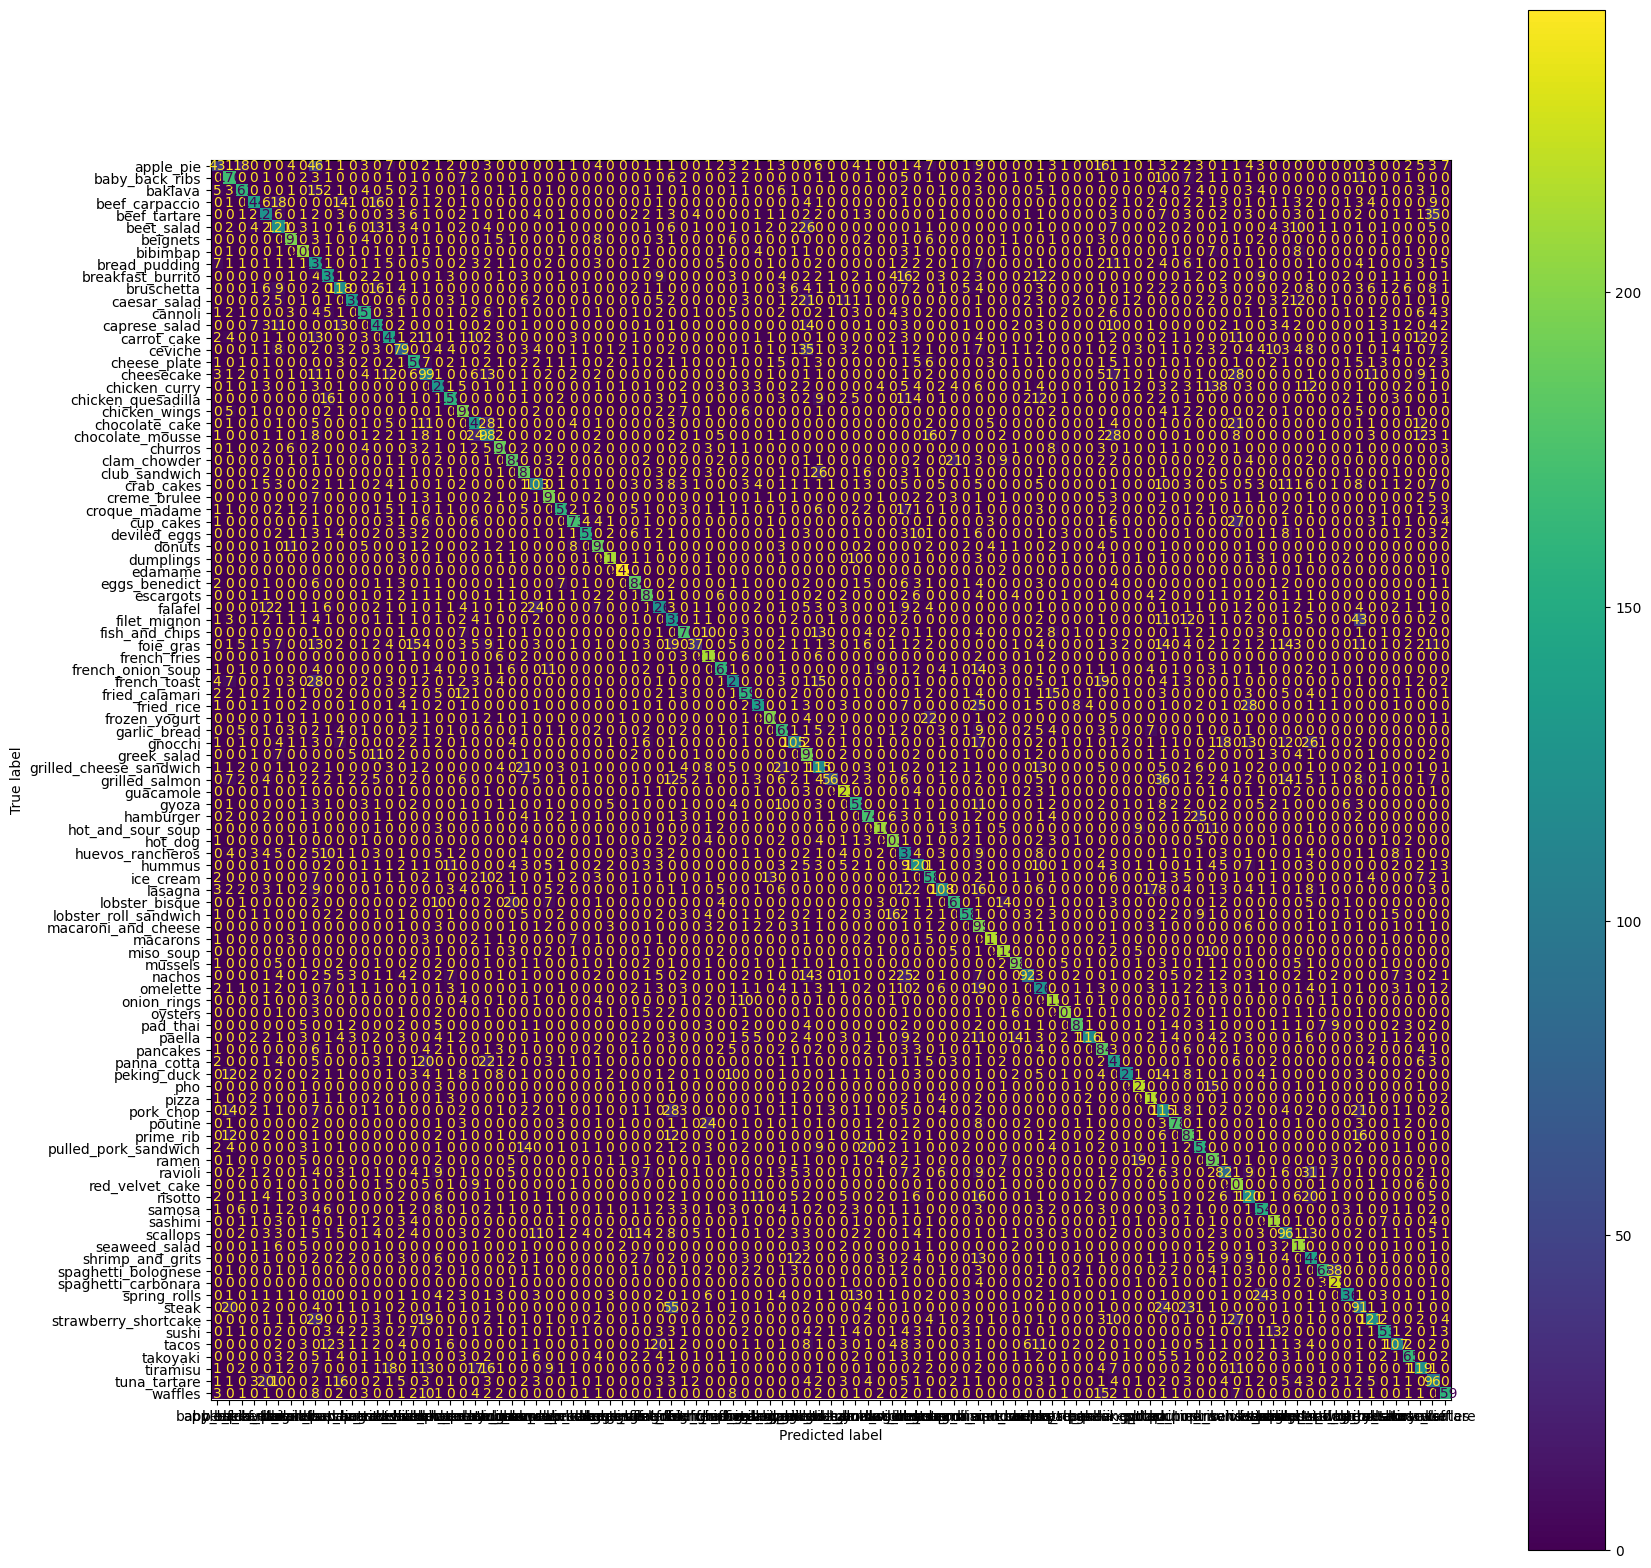

In [45]:
mtrx_plot = ConfusionMatrixDisplay(mtrx, display_labels= test_data.class_names)

fig, ax = plt.subplots(figsize=(20,20))
mtrx_plot.plot(ax=ax)

In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_label, predicts_class))


              precision    recall  f1-score   support

           0       0.42      0.17      0.24       250
           1       0.58      0.68      0.62       250
           2       0.73      0.64      0.68       250
           3       0.77      0.58      0.66       250
           4       0.49      0.50      0.50       250
           5       0.44      0.48      0.46       250
           6       0.79      0.79      0.79       250
           7       0.77      0.84      0.80       250
           8       0.29      0.56      0.38       250
           9       0.56      0.56      0.56       250
          10       0.49      0.47      0.48       250
          11       0.79      0.56      0.65       250
          12       0.72      0.63      0.67       250
          13       0.54      0.59      0.57       250
          14       0.57      0.58      0.57       250
          15       0.44      0.32      0.37       250
          16       0.59      0.62      0.61       250
          17       0.38    

In [42]:
class_names = test_data.class_names

In [43]:
len(class_names)

101

In [46]:
class_names[0]

'apple_pie'

In [47]:
report = classification_report(y_label, predicts_class,output_dict=True, target_names=class_names)



In [48]:
report

{'apple_pie': {'precision': 0.4174757281553398,
  'recall': 0.172,
  'f1-score': 0.24362606232294615,
  'support': 250},
 'baby_back_ribs': {'precision': 0.5782312925170068,
  'recall': 0.68,
  'f1-score': 0.625,
  'support': 250},
 'baklava': {'precision': 0.7252252252252253,
  'recall': 0.644,
  'f1-score': 0.6822033898305084,
  'support': 250},
 'beef_carpaccio': {'precision': 0.7700534759358288,
  'recall': 0.576,
  'f1-score': 0.6590389016018305,
  'support': 250},
 'beef_tartare': {'precision': 0.49407114624505927,
  'recall': 0.5,
  'f1-score': 0.49701789264413515,
  'support': 250},
 'beet_salad': {'precision': 0.4384057971014493,
  'recall': 0.484,
  'f1-score': 0.4600760456273764,
  'support': 250},
 'beignets': {'precision': 0.788,
  'recall': 0.788,
  'f1-score': 0.788,
  'support': 250},
 'bibimbap': {'precision': 0.7655677655677655,
  'recall': 0.836,
  'f1-score': 0.7992351816443595,
  'support': 250},
 'bread_pudding': {'precision': 0.2907949790794979,
  'recall': 0.556

In [64]:
import pandas as pd

report_frame = pd.DataFrame(report).T.sort_values('f1-score', ascending=True)

report_frame.head()

,precision,recall,f1-score,support
foie_gras,0.596774,0.148,0.237179,250.0
apple_pie,0.417476,0.172,0.243626,250.0
grilled_salmon,0.727273,0.224,0.342508,250.0
steak,0.323843,0.364,0.342750,250.0
ravioli,0.414141,0.328,0.366071,250.0


In [57]:
report_frame["f1-score"]

edamame           0.970297
macarons          0.896694
dumplings         0.864097
oysters           0.858921
pho               0.853846
                    ...   
ravioli           0.366071
steak             0.342750
grilled_salmon    0.342508
apple_pie         0.243626
foie_gras         0.237179
Name: f1-score, Length: 104, dtype: float64

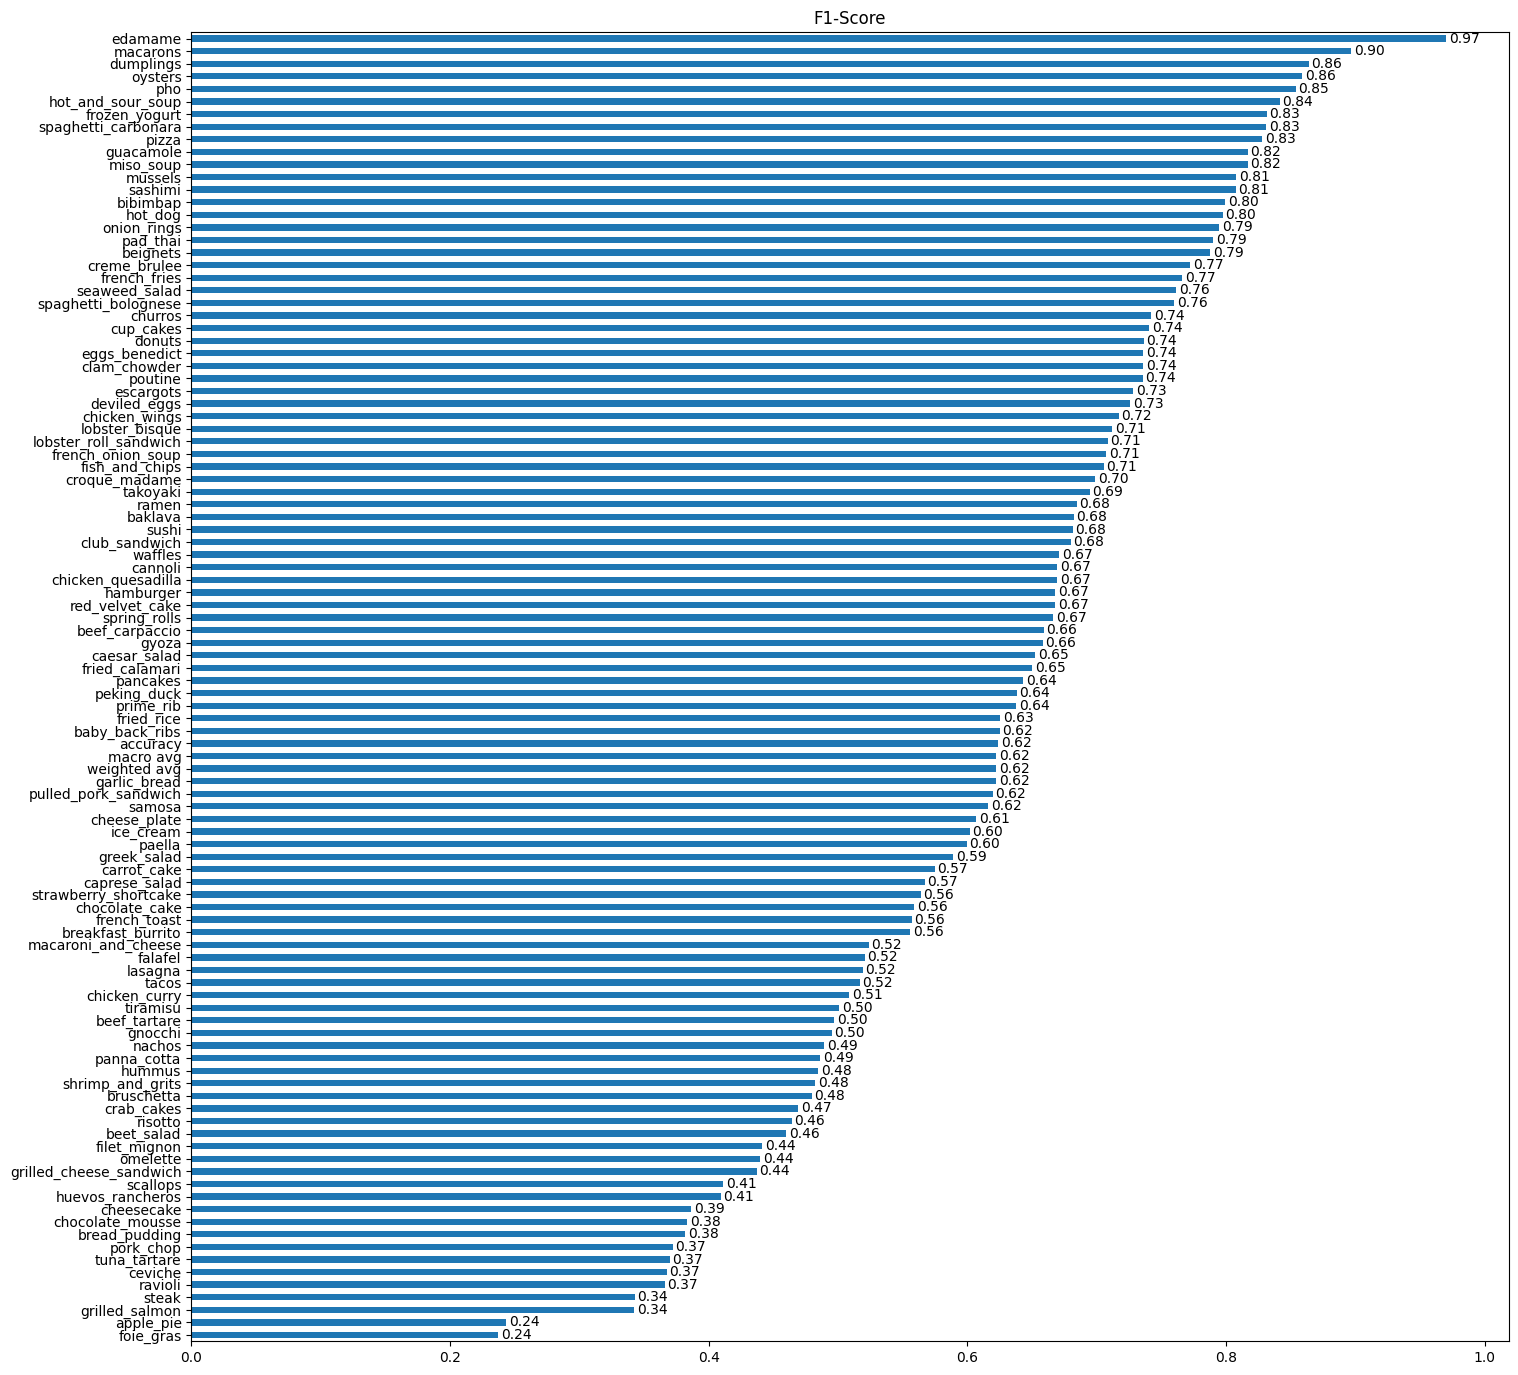

In [88]:
bars = report_frame["f1-score"].plot.barh(figsize=(17,17), title="F1-Score")
bars.bar_label(bars.containers[0], fmt='%.2f', padding = 2)
plt.show()

In [89]:
bars.containers[0]

<BarContainer object of 104 artists>

In [91]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img